In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline

from importlib import reload
from matplotlib import cm
from imblearn.under_sampling import TomekLinks, RandomUnderSampler
from imblearn.over_sampling import SMOTE

import mca
import prince

from sklearn.model_selection import train_test_split
from sklearn.metrics import (make_scorer, roc_auc_score, 
                             classification_report, 
                             precision_recall_curve,
                             roc_curve)
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from xgboost import XGBClassifier

from feature_processing import (create_contingency_table,
                                calculate_conditional_prob_bin,
                                encode_my_categorical_labels,
                                calculate_conditional_prob_cat,
                                estimate_cond_prob_density,
                                bin_myFeature)
import feature_analysis as fa
import porto_seguro as ps

import warnings
warnings.simplefilter("ignore", category=PendingDeprecationWarning)
warnings.simplefilter("ignore", category=DeprecationWarning)

In [2]:
def my_gini(y_true, y_probas):
    auc = roc_auc_score(y_true, y_probas[:, 1])
    gini = 2*auc - 1
    return gini

gini_scorer = make_scorer(my_gini, needs_proba=True, greater_is_better=True)

In [3]:
train = pd.read_csv('train.csv', header=0)

all_fs = train.columns[2:]
binary_fs = sorted([f for f in all_fs if '_bin' in f])
categorical_fs = sorted([f for f in all_fs if '_cat' in f])
other_fs = sorted([f for f in all_fs
            if f not in binary_fs
            if f not in categorical_fs])

binaries = train[binary_fs]
categoricals = ps.fuseCategoricalFeatures(train[categorical_fs])
cont_ordinals = train[other_fs]
target = train.target

train.shape, binaries.shape, categoricals.shape, cont_ordinals.shape

((595212, 59), (595212, 17), (595212, 14), (595212, 26))

In [4]:
all_fs

Index(['ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat',
       'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin',
       'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin',
       'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15', 'ps_ind_16_bin',
       'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03',
       'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat',
       'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat',
       'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_car_11',
       'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_calc_01',
       'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05', 'ps_calc_06',
       'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10', 'ps_calc_11',
       'ps_calc_12', 'ps_calc_13', 'ps_calc_14', 'ps_calc_15_bin',
       'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin',
       'ps_calc_20_bin'],
      dtype='obj

In [5]:
if False:
    converted_cont = ps.convertOrdinalFeatures(cont_ordinals, target, verbose=False)

    new_categoricals = ps.fuseCategoricalFeatures(categoricals)

    bincats = pd.concat([binaries, new_categoricals], axis=1)
    bincat2probas = {}
    for i, f in enumerate(bincats.columns):
        fvt = fa.FeatureVsTarget(bincats[f], target)
        bincat2probas[f] = (100*(fvt.calculate_deviation(mode='ratio')[0] - 1)[1]).to_dict()

    bincat_converted = pd.DataFrame()
    for i, f in enumerate(bincats.columns):
        bincat_converted[f] = bincats[f].replace(bincat2probas[f])

    converted = pd.concat([bincat_converted, converted_cont], axis=1)

In [6]:
ind_fs = [f for f in all_fs if 'ind' in f]
car_fs = [f for f in all_fs if 'car' in f]
calc_fs = [f for f in all_fs if 'calc' in f]
reg_fs = [f for f in all_fs if 'reg' in f]

In [7]:
len(ind_fs), len(car_fs), len(calc_fs), len(reg_fs), len(all_fs)

(18, 16, 20, 3, 57)

In [8]:
inds = train[ind_fs]
cars = train[car_fs]
calcs = train[calc_fs]
regs = train[reg_fs]
y = np.array(target)

In [9]:
inds.head(5)

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin
0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0
1,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1
2,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0
3,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0
4,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0


In [10]:
inds_bincat_fs = [f for f in ind_fs if ('cat' in f) or ('bin' in f)]
inds_bincats = inds[inds_bincat_fs]

In [11]:
# Remove -1 missing data
for f in inds_bincat_fs:
    if -1 in inds_bincats[f].unique():
        inds_bincats[f] = inds_bincats[f] + 1

/home/ryohayama/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [12]:
inds_bincats.head(5)

,ps_ind_02_cat,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin
0,3,2,1,0,1,0,0,0,0,0,0,0,1,0
1,2,1,1,0,0,1,0,0,0,0,0,0,0,1
2,5,2,1,0,0,1,0,0,0,0,0,1,0,0
3,2,1,1,1,0,0,0,0,0,0,0,1,0,0
4,3,2,1,1,0,0,0,0,0,0,0,1,0,0


In [107]:
inds_bincats.shape

(595212, 14)

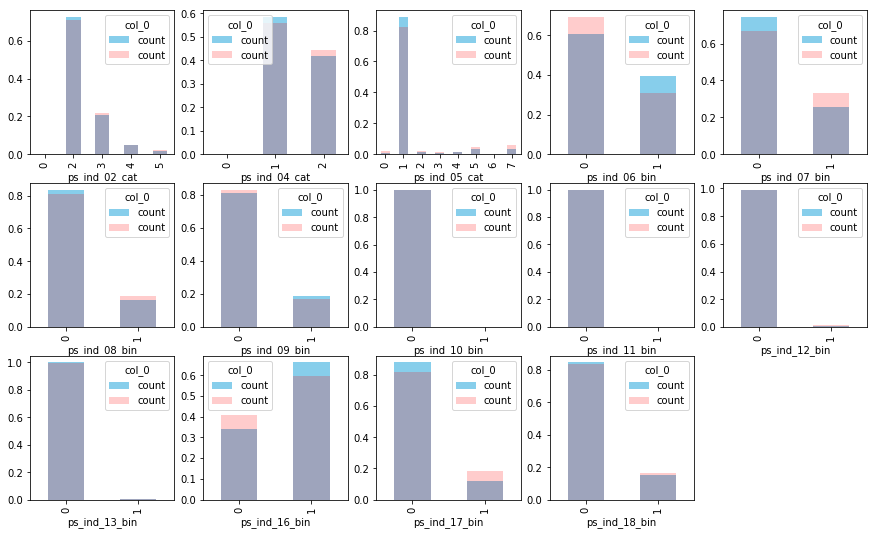

In [111]:
fig = plt.figure(figsize=(15, 9))
for i, f in enumerate(inds_bincats.columns):
    feature = inds_bincats[f]
    bulk = pd.crosstab(index=feature, columns="count")/len(target)
    class1 = pd.crosstab(index=feature[target == 1], columns="count")/np.sum(target)
    
    ax = fig.add_subplot(3, 5, i+1)
    bulk.plot.bar(ax=ax, color='skyblue')
    class1.plot.bar(ax=ax, color='r', alpha=0.2)

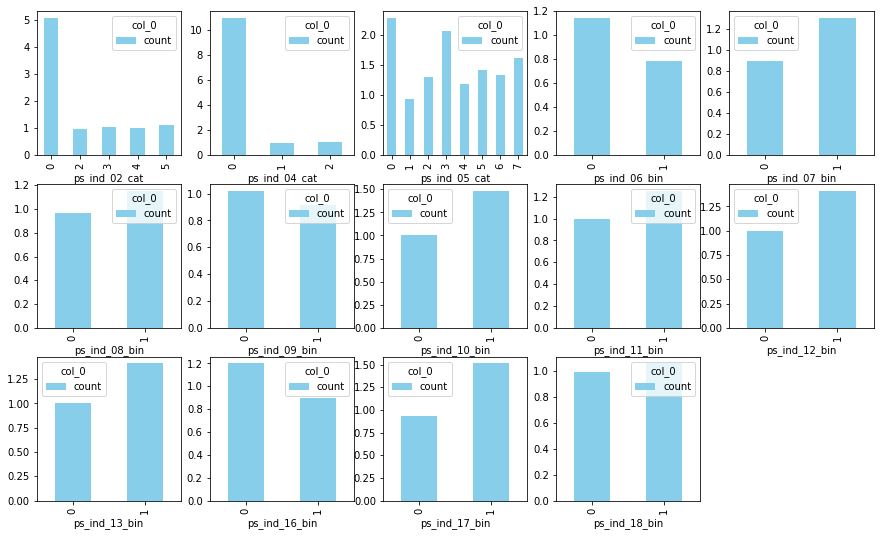

In [112]:
fig = plt.figure(figsize=(15, 9))
for i, f in enumerate(inds_bincats.columns):
    feature = inds_bincats[f]
    bulk = pd.crosstab(index=feature, columns="count")/len(target)
    class1 = pd.crosstab(index=feature[target == 1], columns="count")/np.sum(target)
    ratio = class1/bulk
    
    ax = fig.add_subplot(3, 5, i+1)
    ratio.plot.bar(ax=ax, color='skyblue')

In [113]:
bincats = pd.concat([binaries, train[categorical_fs]], axis=1)

In [114]:
bincats.shape

(595212, 31)

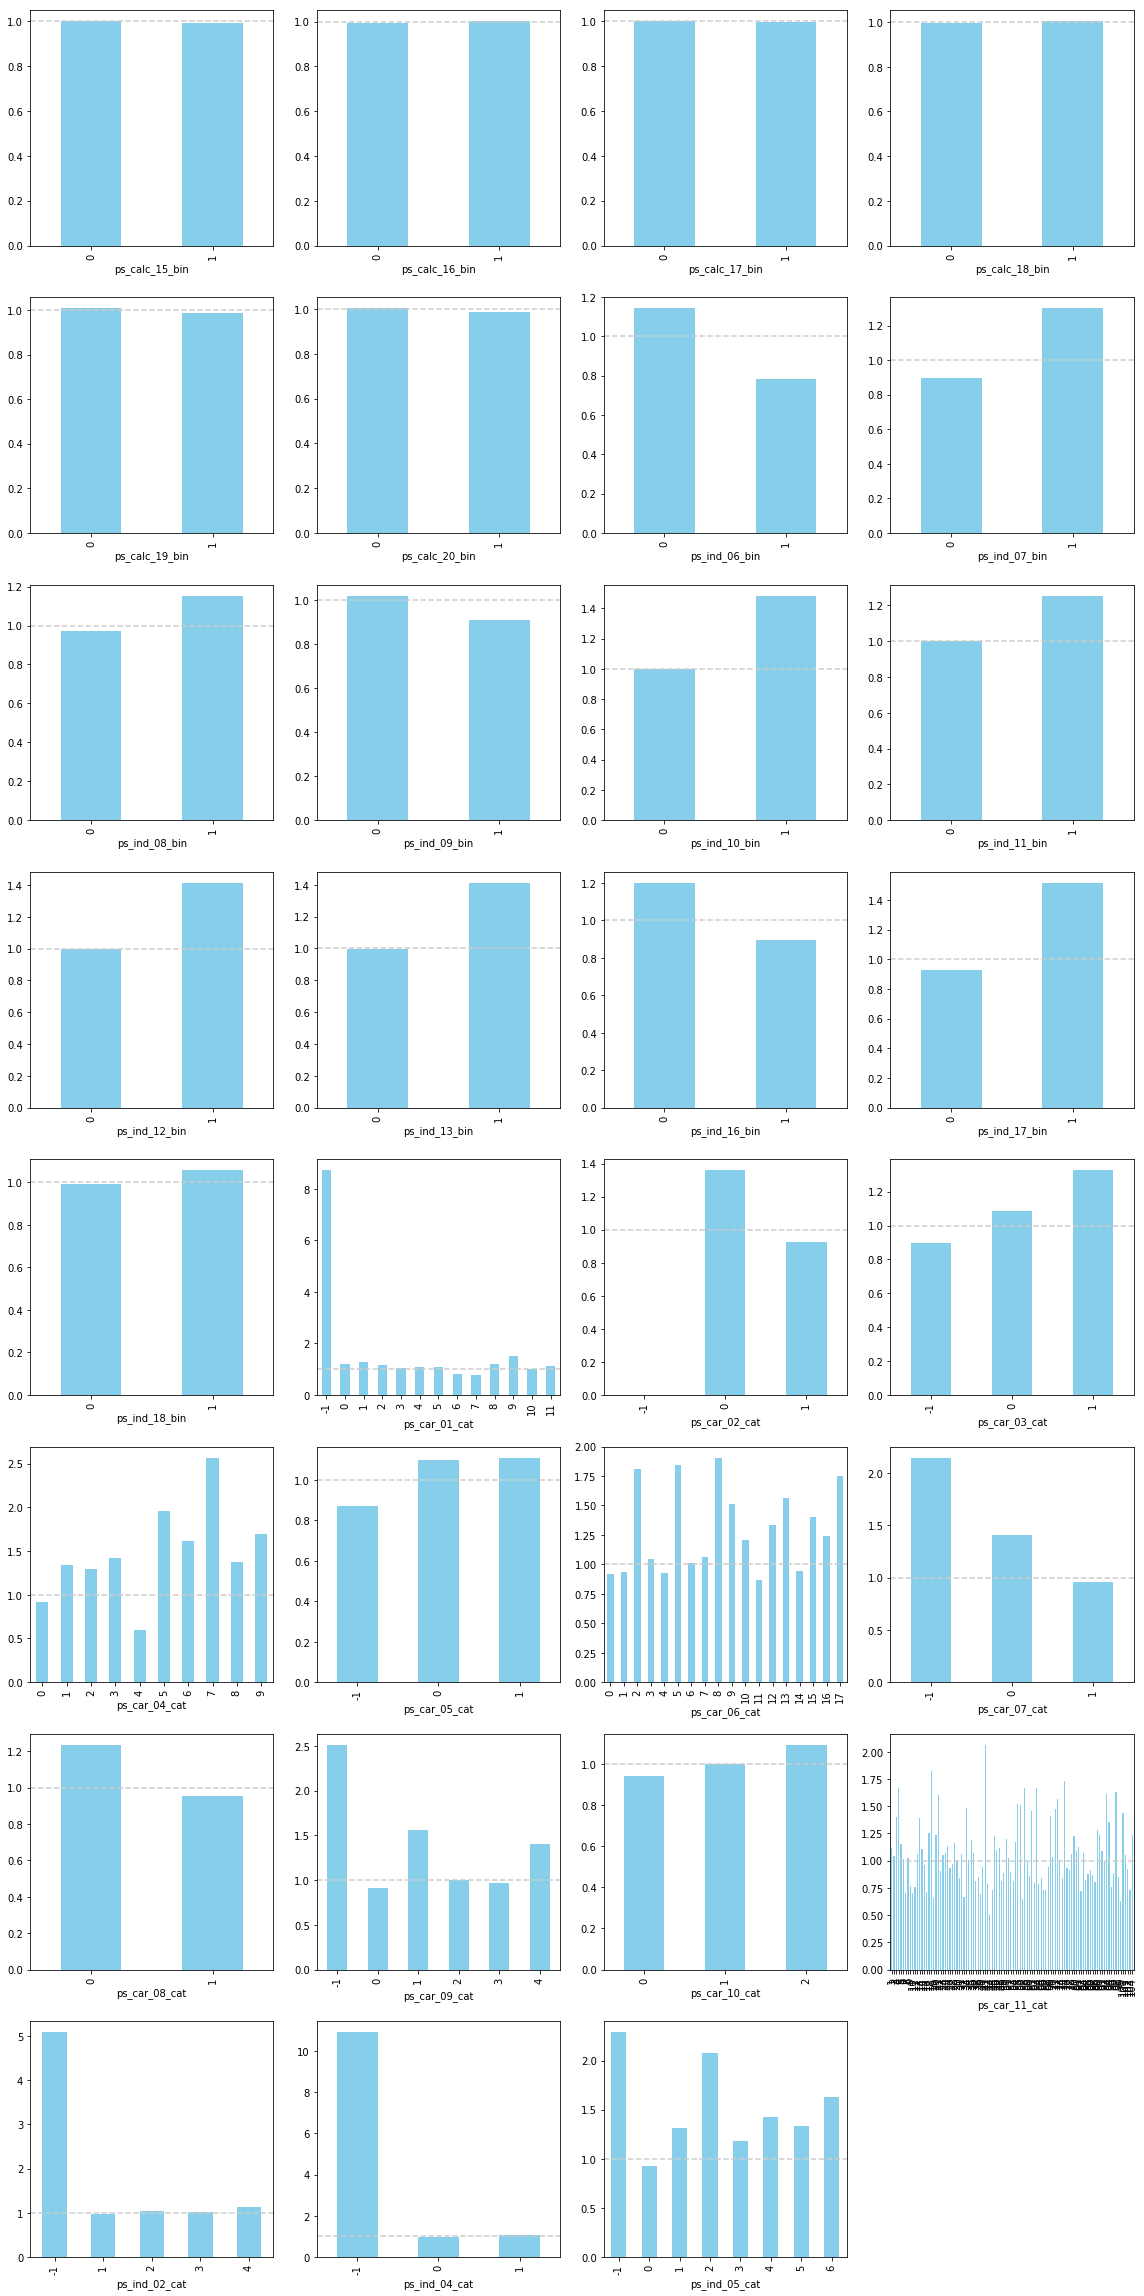

In [118]:
fig = plt.figure(figsize=(16, 32))
for i, f in enumerate(bincats.columns):
    feature = bincats[f]
    bulk = pd.crosstab(index=feature, columns="count")/len(target)
    class1 = pd.crosstab(index=feature[target == 1], columns="count")/np.sum(target)
    ratio = class1/bulk
    
    ax = fig.add_subplot(8, 4, i+1)
    ax.axhline(y=1, color='0.8', ls='--')
    ratio.plot.bar(ax=ax, legend=False, color='skyblue')
plt.tight_layout()

In [124]:
feature = bincats['ps_ind_02_cat']
bulk = pd.crosstab(index=feature, columns="count")/len(target)
class1 = pd.crosstab(index=feature[target == 1], columns="count")/np.sum(target)
ratio = class1/bulk

In [125]:
ratio.to_dict()['count']

{-1: 5.080872335412761,
 1: 0.9801661452234169,
 2: 1.0464196637673429,
 3: 1.0211136532739349,
 4: 1.1188815014598537}

In [126]:
bincats_diff_dist = pd.DataFrame()
fig = plt.figure(figsize=(16, 32))
for i, f in enumerate(bincats.columns):
    feature = bincats[f]
    bulk = pd.crosstab(index=feature, columns="count")/len(target)
    class1 = pd.crosstab(index=feature[target == 1], columns="count")/np.sum(target)
    ratio = class1/bulk
    ratio_dict = ratio.to_dict()['count']
    bincats_diff_dist[f] = feature.replace(ratio_dict)

In [133]:
bincats_diff_dist.shape

(595212, 31)

In [132]:
bincats_diff_dist.dropna().shape

(595207, 31)

In [130]:
bincats_diff_dist.iloc[:, :16].describe()

,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
std,0.002522,0.003208,0.000875,0.002840,0.008966,0.005513,0.174903,0.175938,0.067597,0.042351,0.009331,0.010428,0.040158,0.012650,0.142826,0.190512
min,0.993249,0.995834,0.999215,0.998197,0.987755,0.987045,0.782969,0.896517,0.970069,0.911199,0.999820,0.999571,0.996080,0.999610,0.897676,0.929289
25%,1.000942,0.995834,0.999215,0.998197,0.987755,1.002346,0.782969,0.896517,0.970069,1.020198,0.999820,0.999571,0.996080,0.999610,0.897676,0.929289
50%,1.000942,1.002469,0.999215,0.998197,1.006565,1.002346,1.140953,0.896517,0.970069,1.020198,0.999820,0.999571,0.996080,0.999610,0.897676,0.929289
75%,1.000942,1.002469,1.000975,1.004475,1.006565,1.002346,1.140953,1.299123,0.970069,1.020198,0.999820,0.999571,0.996080,0.999610,1.199359,0.929289
max,1.000942,1.002469,1.000975,1.004475,1.006565,1.002346,1.140953,1.299123,1.152664,1.020198,1.483065,1.253315,1.411394,1.410753,1.199359,1.513285


In [131]:
bincats_diff_dist.iloc[:, 16:].describe()

,ps_ind_18_bin,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_ind_02_cat,ps_ind_04_cat,ps_ind_05_cat
count,595212.000000,595212.000000,595207.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,1.000000,1.000000,1.000008,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
std,0.023423,0.211896,0.162193,0.166809,0.196174,0.117140,0.192174,0.188839,0.104591,0.144292,0.005369,0.257264,0.084069,0.128101,0.223904
min,0.990028,0.789364,0.926591,0.897364,0.596450,0.869984,0.870285,0.953877,0.953014,0.914849,0.943366,0.505479,0.980166,0.954530,0.929143
25%,0.990028,0.789364,0.926591,0.897364,0.917778,0.869984,0.915634,0.953877,0.953014,0.914849,1.000439,0.788199,0.980166,0.954530,0.929143
50%,0.990028,1.030216,0.926591,0.897364,0.917778,1.100501,0.937918,0.953877,0.953014,0.996465,1.000439,0.971620,0.980166,0.954530,0.929143
75%,0.990028,1.140834,0.926591,1.084782,0.917778,1.109913,0.940904,0.953877,0.953014,0.996465,1.000439,1.232277,1.021114,1.060259,0.929143
max,1.055015,8.718207,1.358323,1.325132,2.566023,1.109913,1.904248,2.144500,1.232824,2.507397,1.091233,2.060771,5.080872,10.908572,2.285999


In [142]:
v = pd.concat([bincats_diff_dist, target], axis=1).dropna()
pca = PCA()
Xpca = pca.fit_transform(np.array(v.iloc[:, :-1]))

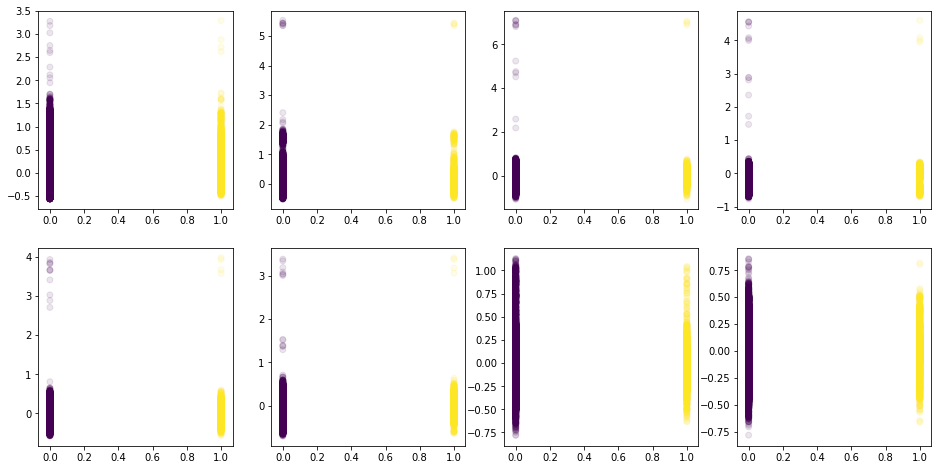

In [152]:
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(16, 8))
ax1.scatter(v.iloc[:, -1][:100000], Xpca[:100000, 0], c=v.iloc[:, -1][:100000], alpha=0.1)#, cmap=cm.bwr, alpha=0.1)
ax2.scatter(v.iloc[:, -1][:100000], Xpca[:100000, 1], c=v.iloc[:, -1][:100000], alpha=0.1)#, cmap=cm.bwr, alpha=0.1)
ax3.scatter(v.iloc[:, -1][:100000], Xpca[:100000, 2], c=v.iloc[:, -1][:100000], alpha=0.1)#, cmap=cm.bwr, alpha=0.1)
ax4.scatter(v.iloc[:, -1][:100000], Xpca[:100000, 3], c=v.iloc[:, -1][:100000], alpha=0.1)#, cmap=cm.bwr, alpha=0.1)
ax5.scatter(v.iloc[:, -1][:100000], Xpca[:100000, 4], c=v.iloc[:, -1][:100000], alpha=0.1)#, cmap=cm.bwr, alpha=0.1)
ax6.scatter(v.iloc[:, -1][:100000], Xpca[:100000, 5], c=v.iloc[:, -1][:100000], alpha=0.1)#, cmap=cm.bwr, alpha=0.1)
ax7.scatter(v.iloc[:, -1][:100000], Xpca[:100000, 6], c=v.iloc[:, -1][:100000], alpha=0.1)#, cmap=cm.bwr, alpha=0.1)
ax8.scatter(v.iloc[:, -1][:100000], Xpca[:100000, 7], c=v.iloc[:, -1][:100000], alpha=0.1)#, cmap=cm.bwr, alpha=0.1)

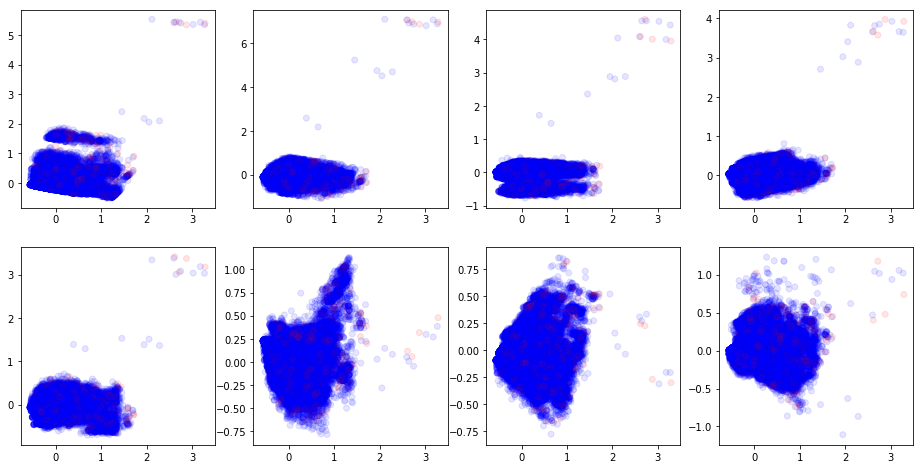

In [160]:
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(16, 8))
ax1.scatter(Xpca[:100000, 0], Xpca[:100000, 1], c=v.iloc[:, -1][:100000], cmap=cm.bwr, alpha=0.1)
ax2.scatter(Xpca[:100000, 0], Xpca[:100000, 2], c=v.iloc[:, -1][:100000], cmap=cm.bwr, alpha=0.1)
ax3.scatter(Xpca[:100000, 0], Xpca[:100000, 3], c=v.iloc[:, -1][:100000], cmap=cm.bwr, alpha=0.1)
ax4.scatter(Xpca[:100000, 0], Xpca[:100000, 4], c=v.iloc[:, -1][:100000], cmap=cm.bwr, alpha=0.1)
ax5.scatter(Xpca[:100000, 0], Xpca[:100000, 5], c=v.iloc[:, -1][:100000], cmap=cm.bwr, alpha=0.1)
ax6.scatter(Xpca[:100000, 0], Xpca[:100000, 6], c=v.iloc[:, -1][:100000], cmap=cm.bwr, alpha=0.1)
ax7.scatter(Xpca[:100000, 0], Xpca[:100000, 7], c=v.iloc[:, -1][:100000], cmap=cm.bwr, alpha=0.1)
ax8.scatter(Xpca[:100000, 0], Xpca[:100000, 8], c=v.iloc[:, -1][:100000], cmap=cm.bwr, alpha=0.1)

In [145]:
a = v.iloc[:, :-1].prod(axis=1)

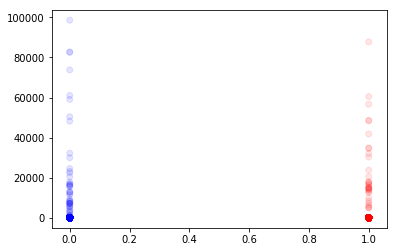

In [147]:
plt.scatter(v.iloc[:, -1], a, c=v.iloc[:, -1], cmap=cm.bwr, alpha=0.1)

In [173]:
from sklearn.decomposition import FastICA

In [174]:
v = pd.concat([bincats_diff_dist, target], axis=1).dropna()
ica = FastICA()
Xica = ica.fit_transform(np.array(v.iloc[:, :-1]))

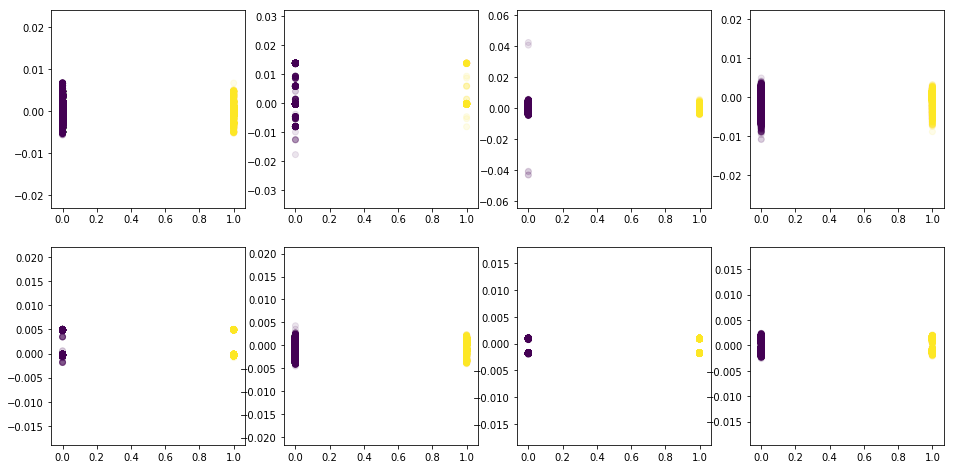

In [175]:
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(16, 8))
ax1.scatter(v.iloc[:, -1][:100000], Xica[:100000, 0], c=v.iloc[:, -1][:100000], alpha=0.1)#, cmap=cm.bwr, alpha=0.1)
ax2.scatter(v.iloc[:, -1][:100000], Xica[:100000, 1], c=v.iloc[:, -1][:100000], alpha=0.1)#, cmap=cm.bwr, alpha=0.1)
ax3.scatter(v.iloc[:, -1][:100000], Xica[:100000, 2], c=v.iloc[:, -1][:100000], alpha=0.1)#, cmap=cm.bwr, alpha=0.1)
ax4.scatter(v.iloc[:, -1][:100000], Xica[:100000, 3], c=v.iloc[:, -1][:100000], alpha=0.1)#, cmap=cm.bwr, alpha=0.1)
ax5.scatter(v.iloc[:, -1][:100000], Xica[:100000, 4], c=v.iloc[:, -1][:100000], alpha=0.1)#, cmap=cm.bwr, alpha=0.1)
ax6.scatter(v.iloc[:, -1][:100000], Xica[:100000, 5], c=v.iloc[:, -1][:100000], alpha=0.1)#, cmap=cm.bwr, alpha=0.1)
ax7.scatter(v.iloc[:, -1][:100000], Xica[:100000, 6], c=v.iloc[:, -1][:100000], alpha=0.1)#, cmap=cm.bwr, alpha=0.1)
ax8.scatter(v.iloc[:, -1][:100000], Xica[:100000, 7], c=v.iloc[:, -1][:100000], alpha=0.1)#, cmap=cm.bwr, alpha=0.1)

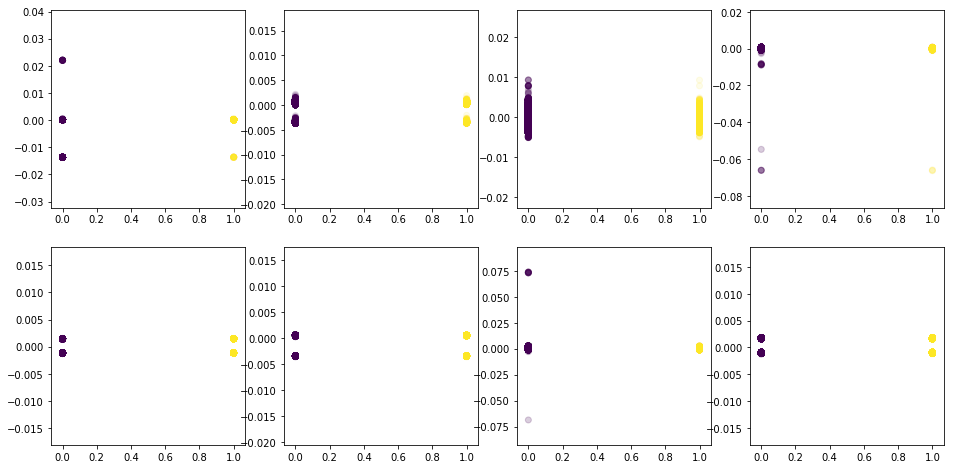

In [176]:
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(16, 8))
ax1.scatter(v.iloc[:, -1][:100000], Xica[:100000, 9], c=v.iloc[:, -1][:100000], alpha=0.1)#, cmap=cm.bwr, alpha=0.1)
ax2.scatter(v.iloc[:, -1][:100000], Xica[:100000, 10], c=v.iloc[:, -1][:100000], alpha=0.1)#, cmap=cm.bwr, alpha=0.1)
ax3.scatter(v.iloc[:, -1][:100000], Xica[:100000, 11], c=v.iloc[:, -1][:100000], alpha=0.1)#, cmap=cm.bwr, alpha=0.1)
ax4.scatter(v.iloc[:, -1][:100000], Xica[:100000, 12], c=v.iloc[:, -1][:100000], alpha=0.1)#, cmap=cm.bwr, alpha=0.1)
ax5.scatter(v.iloc[:, -1][:100000], Xica[:100000, 13], c=v.iloc[:, -1][:100000], alpha=0.1)#, cmap=cm.bwr, alpha=0.1)
ax6.scatter(v.iloc[:, -1][:100000], Xica[:100000, 14], c=v.iloc[:, -1][:100000], alpha=0.1)#, cmap=cm.bwr, alpha=0.1)
ax7.scatter(v.iloc[:, -1][:100000], Xica[:100000, 15], c=v.iloc[:, -1][:100000], alpha=0.1)#, cmap=cm.bwr, alpha=0.1)
ax8.scatter(v.iloc[:, -1][:100000], Xica[:100000, 16], c=v.iloc[:, -1][:100000], alpha=0.1)#, cmap=cm.bwr, alpha=0.1)

In [153]:
from sklearn.linear_model import LinearRegression

In [154]:
v = pd.concat([bincats_diff_dist, target], axis=1).dropna()
X = np.array(v.iloc[:, :-1])
y = np.array(v.iloc[:, -1])

lr = LinearRegression(n_jobs=8)
lr.fit(X, y)

y_predict = lr.predict(X)

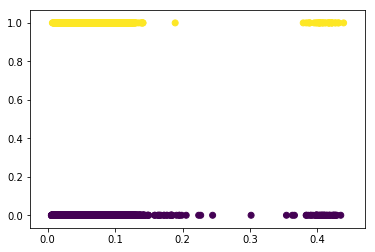

In [157]:
plt.scatter(y_predict, y, c=y)

## MCA

In [166]:
mca_counts = mca.MCA(inds_bincats.iloc[:10000, :])#, None, 10)

In [167]:
a = mca_counts.fs_r(1)

In [168]:
a.shape

(10000, 9)

In [169]:
mca_counts.L

array([ 0.01573289,  0.00812297,  0.00678225,  0.00673208,  0.00472993,
        0.00369227,  0.00116147,  0.0008128 ,  0.00078272])

In [170]:
mca_counts.inertia

0.048583362627389437

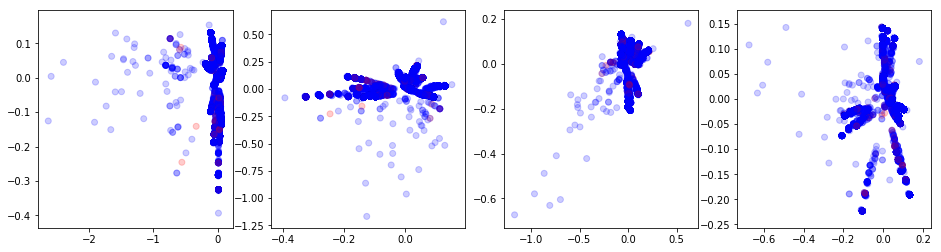

In [171]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 4))
ax1.scatter(a[:, 0], a[:, 1], c=target.iloc[:10000], cmap=cm.bwr, alpha=0.2)
ax2.scatter(a[:, 1], a[:, 2], c=target.iloc[:10000], cmap=cm.bwr, alpha=0.2)
ax3.scatter(a[:, 2], a[:, 3], c=target.iloc[:10000], cmap=cm.bwr, alpha=0.2)
ax4.scatter(a[:, 3], a[:, 4], c=target.iloc[:10000], cmap=cm.bwr, alpha=0.2)

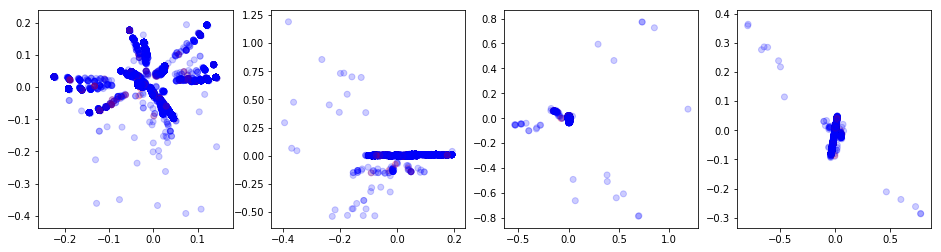

In [172]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 4))
ax1.scatter(a[:, 4], a[:, 5], c=target.iloc[:10000], cmap=cm.bwr, alpha=0.2)
ax2.scatter(a[:, 5], a[:, 6], c=target.iloc[:10000], cmap=cm.bwr, alpha=0.2)
ax3.scatter(a[:, 6], a[:, 7], c=target.iloc[:10000], cmap=cm.bwr, alpha=0.2)
ax4.scatter(a[:, 7], a[:, 8], c=target.iloc[:10000], cmap=cm.bwr, alpha=0.2)

## Some plots with continuous variables

In [55]:
cont_fs = ['ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05',
       'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10',
       'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14', 'ps_car_11',
       'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_ind_01',
       'ps_ind_03', 'ps_ind_14', 'ps_ind_15', 'ps_reg_01', 'ps_reg_02',
       'ps_reg_03']
conts = train[cont_fs]

In [56]:
conts.shape

(595212, 26)

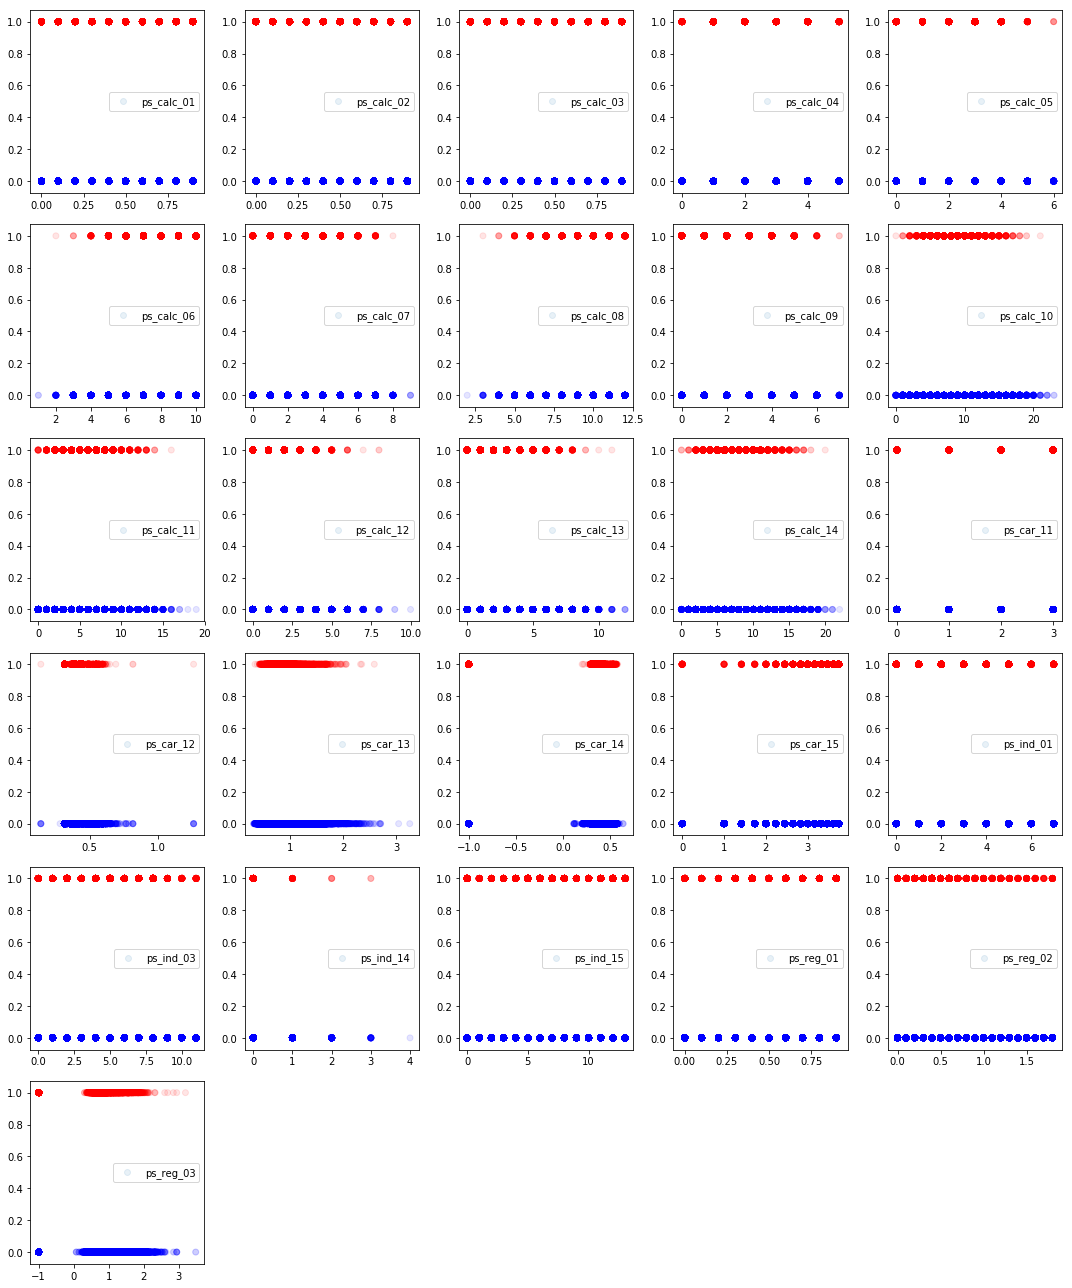

In [60]:
fig = plt.figure(figsize=(15, 18))
for i, f in enumerate(cont_fs):
    x = conts[f][:100000]
    y = target[:100000]
    
    ax = fig.add_subplot(6, 5, i+1)
    ax.scatter(x, y, c=y, cmap=cm.bwr, alpha=0.1, label=f)
    ax.legend()
plt.tight_layout()